### HighIQ spectral processing example.

This notebook shows an example of how to process Doppler spectra from complex autocorrelation function (ACF) data. The example data in this notebook are from the Atmospheric Radiation Measurement program's Doppler Lidar in the Southern Great Plains site in Oklahoma. 

In [1]:
import highiq
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
file_path = '/nfs/gce/projects/digr/sgp_lidar/sgpdlacfC1.a1.20170804.000113.nc.v0'

HighIQ uses xarray as its basic data model. Therefore, if you have ACF data in netCDF format, HighIQ will be able to load it without any preprocessing steps. The input dataset must contain 2 four dimensional arrays where the dimensions represent (time, number of samples, number of lags, and real/complex component) such as in the example dataset below.

In [3]:
my_ds = highiq.io.load_arm_netcdf(file_path)
my_ds

<xarray.Dataset>
Dimensions:      (complex: 2, nlags: 20, nsamples: 4000, time: 2184)
Coordinates:
  * nlags        (nlags) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * complex      (complex) int16 1 2
  * time         (time) datetime64[ns] 2017-08-04T00:01:13.070000 ... 2017-08-04T00:59:59.900000
Dimensions without coordinates: nsamples
Data variables:
    base_time    (time) datetime64[ns] 2017-08-04 2017-08-04 ... 2017-08-04
    time_offset  (time) datetime64[ns] dask.array<chunksize=(2184,), meta=np.ndarray>
    azimuth      (time) float32 dask.array<chunksize=(2184,), meta=np.ndarray>
    elevation    (time) float32 dask.array<chunksize=(2184,), meta=np.ndarray>
    acf_bkg      (time, nsamples, nlags, complex) float32 dask.array<chunksize=(2184, 4000, 20, 2), meta=np.ndarray>
    acf          (time, nsamples, nlags, complex) float32 dask.array<chunksize=(2184, 4000, 20, 2), meta=np.ndarray>
    lat          (time) float32 36.6053 36.6053 36.6053 ... 36.6053 36.6053

The first step with this dataset is to process the doppler spectra from the ACF data. HighIQ makes this easy given you have an xarray dataset that has similar specifications to the dataset above. 

In [4]:
my_ds = highiq.calc.get_psd(my_ds)
my_ds

/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


<xarray.Dataset>
Dimensions:                        (complex: 2, freq: 32, nlags: 20, nsamples: 4000, range: 400, time: 2184, vel_bin_interp: 256, vel_bins: 32)
Coordinates:
  * range                          (range) int64 0 30 60 ... 11910 11940 11970
  * time                           (time) datetime64[ns] 2017-08-04T00:01:13.070000 ... 2017-08-04T00:59:59.900000
  * vel_bin_interp                 (vel_bin_interp) float64 -1.935e+04 ... 1.814e+04
  * vel_bins                       (vel_bins) float64 -1.935e+04 ... 1.814e+04
  * nlags                          (nlags) int16 0 1 2 3 4 5 ... 15 16 17 18 19
  * complex                        (complex) int16 1 2
Dimensions without coordinates: freq, nsamples
Data variables:
    base_time                      (time) datetime64[ns] 2017-08-04 ... 2017-08-04
    time_offset                    (time) datetime64[ns] dask.array<chunksize=(2184,), meta=np.ndarray>
    azimuth                        (time) float32 dask.array<chunksize=(2184,), met

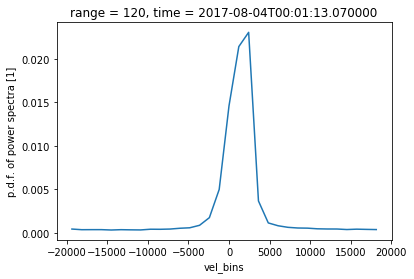

In [5]:
my_ds["power_spectra_normed"].isel(time=0, range=4).plot()